## Image GPT

#### (Last Report's Topic)

Resources Used: https://github.com/openai/image-gpt/blob/master/src/model.py

https://github.com/teddykoker/image-gpt/blob/master/src/gpt2.py


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Utility Functions

In [3]:
import os
import json
import time
import pickle
import subprocess
import math
from sklearn.cluster import MiniBatchKMeans, KMeans

def find_centroids(train_x, num_clusters=216, batch_size=1024): #num clusters should equal n_vocab
    pixels = train_x.reshape(-1, train_x.shape[-1])
    if batch_size:
        kmeans = MiniBatchKMeans(
            n_clusters=num_clusters, random_state=0, batch_size=batch_size
        ).fit(pixels)
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pixels)
    return kmeans.cluster_centers_

def squared_euclidean_distance(a, b):
    b = torch.transpose(b, 0, 1)
    a2 = torch.sum(torch.pow(a, 2), dim=1, keepdims=True)
    b2 = torch.sum(torch.pow(b, 2), dim=0, keepdims=True)
    ab = torch.matmul(a, b)
    d = a2 - 2 * ab + b2
    return d


def quantize(x, centroids):
    b, c, h, w = x.shape
    # [B, C, H, W] => [B, H, W, C]
    x = x.permute(0, 2, 3, 1).contiguous()
    x = x.view(-1, c)  # flatten to pixels
    d = squared_euclidean_distance(x, centroids)
    x = torch.argmin(d, 1)
    x = x.view(b, h, w)
    return x


def unquantize(x, centroids):
    return centroids[x]

def _to_sequence(x):
    """shape batch of images for input into GPT2 model"""
    x = x.view(x.shape[0], -1)  # flatten images into sequences
    x = x.transpose(0, 1).contiguous()  # to shape [seq len, batch]
    return x

- Find Centroids: Utilizes K means to find centroids that will be used in vector quantization. Typically set the number of clusters to n_vocab parameter.
- squared euclidean distance: simple distance calculation using tensors
- quantize: function that quantizes the vector by comparing distances of tensor to centroids.
- to sequence: translates image data into a sequence as it would be used in an NLP model

## Model Building

In [4]:
class block(nn.Module):
    def __init__(self, nx, n_head):
        super(block, self).__init__()
        
        self.nx = nx
        self.n_head = n_head
        
        self.layer_norm1 = nn.LayerNorm(self.nx)
        self.layer_norm2 = nn.LayerNorm(self.nx)
        self.mlp = nn.Sequential(
            nn.Linear(self.nx, self.nx*4), #technically a "Conv1D" but Linear b.c. sequence data
            nn.GELU(),
            nn.Linear(self.nx*4, self.nx),
        )
        self.multiattn = nn.MultiheadAttention(self.nx, self.n_head)    
        
    def forward(self, x):

      #  mask = torch.triu(torch.ones(len(x), len(x), device=x.device), diagonal=1)
        mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        mask = torch.triu(mask, diagonal=1)
        
        x = self.layer_norm1(x)
            
        attn_output, attn_output_weights = self.multiattn(x,x,x, attn_mask = mask, need_weights=False)
        x = x + attn_output
        x = self.layer_norm2(x)
        m = self.mlp(x)
        x = x + m
        return x



class img_gpt(nn.Module):
    def __init__(self, hparams, clf = False):
        super(img_gpt, self).__init__()
    
        self.hparams = hparams      
        self.blocks = nn.ModuleList(block(self.hparams.nx, self.hparams.n_head) for i in range(self.hparams.n_layer))
        
        self.sos = nn.Parameter((torch.zeros(self.hparams.nx)))
        nn.init.normal_(self.sos, std=0.02)
        
        self.embeddings_tok = nn.Embedding(self.hparams.n_vocab, self.hparams.nx)
        self.embeddings_pos = nn.Embedding(self.hparams.n_pos, self.hparams.nx)
        
        self.layer_norm = nn.LayerNorm(self.hparams.nx)
        self.head = nn.Linear(self.hparams.nx, self.hparams.n_vocab, bias=False)
        self.clf_head = nn.Linear(self.hparams.nx, self.hparams.n_classes)
        
    def forward(self, x):
        presents = []
        seq, batch = x.shape
        
        h = self.embeddings_tok(x)
        sos_tok = torch.ones(1, batch, self.hparams.nx).cuda()
        sos_tok = sos_tok*self.sos
        h = torch.cat([sos_tok, h[:-1,:,:]], axis=0)
        pos = torch.arange(seq, device=x.device).unsqueeze(-1)
        
        h = h + self.embeddings_pos(pos).expand_as(h)
        count=0
        for layer in self.blocks:
            h = layer(h)
            count+=1
        logits = self.head(h)
        
        if not self.hparams.clf:
            return logits
        
        h=torch.mean(h, dim=0)
        
        return self.clf_head(h), logits

### Description of Code Above
Let us reference this image found in the paper Attention is All You Need in understanding the code:

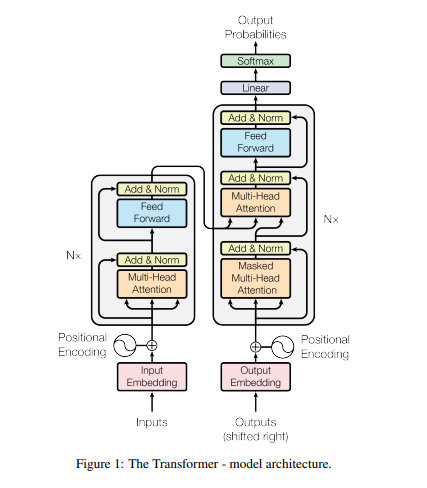

- The transformer decoder is essentially the right half of this image. We take the input and apply masked multihead attention which lives in the block class. We see that there is a residual connection, which is equivalent to the "x + attention_output" in the forward pass. We then repeat this process for however many blocks we have which are specified as a hyperparameter, n_layer. Also in the block lives our feed forward pass, which is our class attribute mlp. From this we can obtain logits which we apply a softmax in order to calculate the categorical cross entropy loss.

## Training

I'm going to be using CIFAR-10 here to pre-train the network.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Compute centroids to quantize data

In [100]:
#Train if needed here for centroids

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform= transforms.ToTensor(), target_transform=None, download=True)
numpy_train_data =np.stack([x.numpy() for x, _ in dataset])
numpy_train_data = numpy_train_data.transpose(0,2,3,1)

centroids = torch.from_numpy(find_centroids(numpy_train_data, num_clusters=16)).float()
del numpy_train_data
del dataset

torch.save(centroids, 'cifar10_centroids')
centroids = torch.load('cifar10_centroids')

Files already downloaded and verified


### Define Hyperparameters

In [7]:
class hparams():
    def __init__(self, nx=16, n_head=2, n_layer=8, n_px=32, n_vocab=16, clf=False, classes=10):
        
        self.nx = nx
        self.n_head = n_head
        self.n_layer = n_layer
        self.n_vocab = n_vocab
        self.clf = clf
        self.n_classes = classes
        self.n_pos = n_px*n_px
        
        
default_hparams = hparams()   

model = img_gpt(default_hparams).to(device)

### Training

In [8]:
loss_fn = nn.CrossEntropyLoss()

training_errors = []
validation_accuracy = []
correct = 0
total = 0
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    if epoch % 10 == 0:
        print(epoch)
            
    for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0], data[1]
        inputs = quantize(inputs, centroids)
        inputs = _to_sequence(inputs).to(device)


        # zero the parameter gradients
        optimizer.zero_grad()


        if default_hparams.clf:
            clf_logit, gen_logit = model(inputs, clf=True)
            clf_loss = loss_fn(clf_logit, labels)
            gen_loss = loss_fn(gen_logit.view(-1, gen_logit.size(-1)), inputs.view(-1))
            loss = clf_loss + gen_loss

        else:
            gen_logit = model(inputs)
            loss = loss_fn(gen_logit.view(-1, gen_logit.size(-1)), inputs.view(-1))    
        
        loss.backward()
        optimizer.step()    

0


In [9]:
save = torch.save(model, './img_gpt_model')

In [10]:
model = torch.load('./img_gpt_model').eval().to(device)

In [89]:
def sample(model, context, length, num_samples=1, temperature=1.0):

    output = context.unsqueeze(-1).repeat_interleave(
        num_samples, dim=-1
    )  # add batch so shape [seq len, batch]
   
    pad = torch.zeros(1, num_samples, dtype=torch.long).cuda()  # to pad prev output
    with torch.no_grad():
        for _ in range(length):
            logits = model(torch.cat((output.cuda(), pad), dim=0))
            logits = logits[-1, :, :] / temperature
            probs = F.softmax(logits, dim=-1)
            pred = torch.multinomial(probs, num_samples=1).transpose(1, 0)
            output = torch.cat((output, pred), dim=0)
    return output


def make_figure(rows, centroids):
    figure = np.stack(rows, axis=0)
    rows, cols, h, w = figure.shape
    figure = unquantize(figure.swapaxes(1, 2).reshape(h * rows, w * cols), centroids).numpy()
    figure = (figure * 256).astype(np.uint8)
    return Image.fromarray(np.squeeze(figure))

Above are the functions to generate image samples given context (half of the image in our case), the length which will be half of the length of the sequence, and the number of samples.

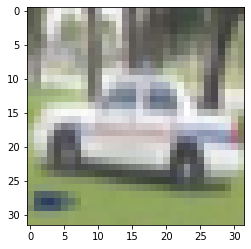

  car


In [12]:
imgset_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)

# get some random training images
dataiter = iter(imgset_loader)
images, labels = dataiter.next()

In [116]:
examples = 5

labels = []
rows = []

for i in range(examples):
    image, label = dataiter.next()
    h, w = image.shape[-2:]
    quantize_img = quantize(image, centroids).numpy()[0]
    seq_img = quantize_img.reshape(-1)

    context = seq_img[: int(len(seq_img)/2)]
    context_img = np.pad(context, (0, int(len(seq_img) / 2))).reshape(h,w)
    context = torch.from_numpy(context).cuda()

    pred = sample(model, context, int(len(seq_img)/2), num_samples = 5).cpu().numpy().transpose()
    pred = pred.reshape(-1, h ,w)
    
    rows.append(np.concatenate([context_img[None,...], pred, image[0]], axis=0))

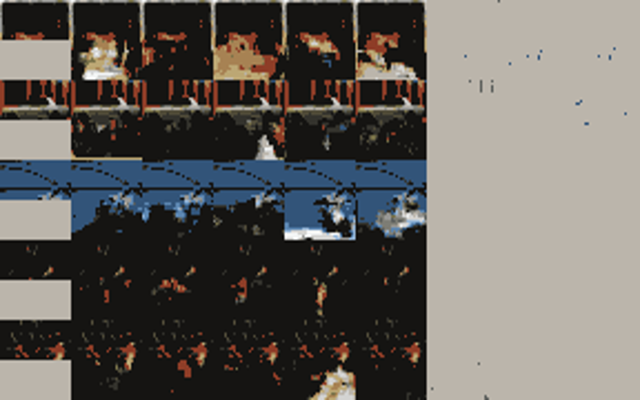

In [122]:
make_figure(rows, centroids).resize((640,400))

While the images are low resolution, I still find it impressive that we're able to accomplish this with an NLP architecture! This is only after training for several epochs as training takes an extremely long time, so results could be more interesting with additional training. In their blog post they noted that the computations were inefficient as they did not want to hand code an architecture for image data. I think it would be an interesting follow up to see how we could improve the speed of the model by inserting modules better suited for image computations. Additionally, I would like to try higher resolution images and train for a longer period so we can better make out the features we are seeing.